In [1]:
import collections
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# For recent conferences, I've had HotCRP complain about missing fonts unless I include this line
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def time_to_secs(time_string):
    secs = 0
    tokens = time_string.split(":")
    if len(tokens) == 3:
        hours = int(tokens[0])
        secs += 3600 * hours
        tokesn = tokens[1:]
    assert(len(tokens) == 2)
    minutes = int(tokens[0])
    secs += 60 * minutes
    secs += float(tokens[1])
    return secs

In [3]:
MeasurementTuple = collections.namedtuple("MeasurementTuple", ("ratio",
                                                               "num_major_faults",
                                                               "num_total_faults",
                                                               "wall_clock_time",
                                                               "pages_evicted",
                                                               "pages_swapped_in"))

class Measurement(MeasurementTuple):
    @property
    def num_minor_faults(self):
        return self.num_total_faults - self.num_major_faults

class RatioSweep(object):
    def __init__(self, stats_filename, cgroup_filename):
        # Maps ratio (100, 90, 80, etc.) to Measurement object describing the stat
        self.ratio = {}
        
        # Maps ratio to list of rows
        with open(stats_filename) as sf:
            sr = csv.DictReader(sf)
            stats_by_row = {int(row["RATIO"]) : row for row in sr}
        with open(cgroup_filename) as cf:
            cr = csv.DictReader(cf)
            cgroup_by_row = {int(row["RATIO"]) : row for row in cr}
                
        for ratio in stats_by_row:
            stats = stats_by_row[ratio]
            cgroup = cgroup_by_row[ratio]
            self.ratio[ratio] = Measurement(ratio,
                                            int(cgroup["NUM_MAJOR_FAULTS"]),
                                            int(cgroup["NUM_FAULTS"]),
                                            time_to_secs(stats["WALLCLOCK"]),
                                            int(stats["PAGES_EVICTED"]),
                                            int(stats["PAGES_SWAPPED_IN"]))

In [4]:
def parse_ratio_sweep(system, experiment_name, setup, base_directory = "."):
    if system == "tape":
        first_directory = "tape_bench_output"
        if setup == "linux":
            third_directory = "linux_prefetching_asyncwrites"
        elif setup == "linux_sync":
            third_directory = "linux_prefetching"
        elif setup == "tape":
            third_directory = "tape_prefetching_asyncwrites"
        else:
            raise RuntimeError("Can't handle {0}".format((system, experiment_name, setup)))
        stats_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "time_and_swap_results.csv")
        cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, third_directory, "cgroup_results.csv")
        return RatioSweep(stats_filename, cgroup_filename)
    elif system == "leap":
        first_directory = "leap_bench_output"
        if setup == "linux" or setup == "linux_sync":
            stats_filename = os.path.join(base_directory, first_directory, experiment_name, "linux.stats")
            cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, "linux.cgroup")
        elif setup == "leap":
            stats_filename = os.path.join(base_directory, first_directory, experiment_name, "leap.stats")
            cgroup_filename = os.path.join(base_directory, first_directory, experiment_name, "leap.cgroup")
        else:
            raise RuntimeError("Can't handle {0}".format((system, experiment_name, setup)))
        return RatioSweep(stats_filename, cgroup_filename)
    else:
        raise RuntimeError("Can't handle system {0}".format(system))

In [5]:
RATIOS = (5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)

In [6]:
tape_style = {"label": "3PO", "color": "blue", "marker": "s", "ls": "-"}
linux_tape_style = {"label": "Linux (Fastswap* Backend)", "color": "green", "marker": "v", "ls": "--"}
leap_style = {"label": "Leap", "color": "red", "marker": "o", "ls": "-."}
linux_leap_style = {"label": "Linux (Leap Backend)", "color": "purple", "marker": "^", "ls": ":"}

In [7]:
def get_tape_vs_leap(workload, base_directory = "."):
    tape = parse_ratio_sweep("tape", workload, "tape", base_directory)
    linux_tape = parse_ratio_sweep("tape", workload, "linux", base_directory)
    leap = parse_ratio_sweep("leap", workload, "leap", base_directory)
    linux_leap = parse_ratio_sweep("leap", workload, "linux", base_directory)
    return tape, linux_tape, leap, linux_leap

In [8]:
def plot_tape_vs_leap(workload, extract, base_directory = "."):
    tape, linux_tape, leap, linux_leap = get_tape_vs_leap(workload, base_directory)
    plt.plot(RATIOS, [extract(tape.ratio[r]) for r in RATIOS], **tape_style)
    plt.plot(RATIOS, [extract(linux_tape.ratio[r]) for r in RATIOS], **linux_tape_style)
    plt.plot(RATIOS, [extract(leap.ratio[r]) for r in RATIOS], **leap_style)
    plt.plot(RATIOS, [extract(linux_leap.ratio[r]) for r in RATIOS], **linux_leap_style)

Matrix Multiply (mmult_eigen, size = 4096)
------------------------------------------------------------

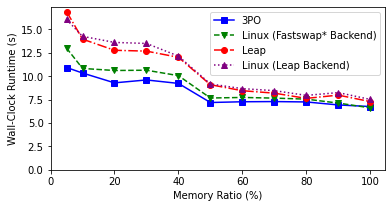

In [9]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

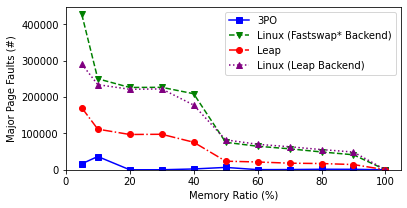

In [10]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen", lambda m: m.num_major_faults, "single")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

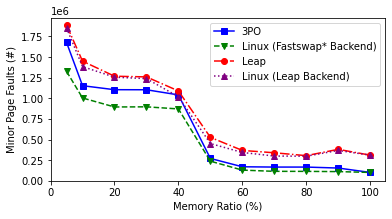

In [11]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen", lambda m: m.num_minor_faults, "single")

plt.ylabel("Minor Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

Matrix Multiply, p = 3
------------------------------

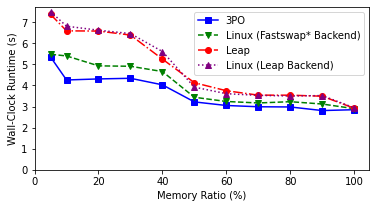

In [12]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_par_3", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

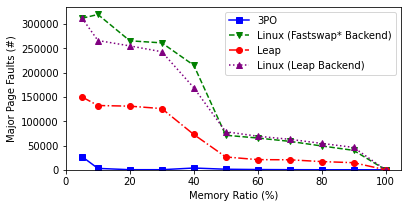

In [13]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_par_3", lambda m: m.num_major_faults, "single")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

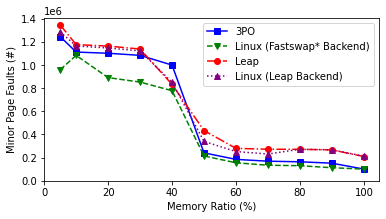

In [14]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_par_3", lambda m: m.num_minor_faults, "single")

plt.ylabel("Minor Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

Matrix-Vector Multiply (mmult_eigen_vec, size = 16384)
------------------------------------------------------------------------------

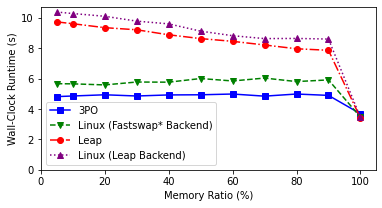

In [15]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_vec", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

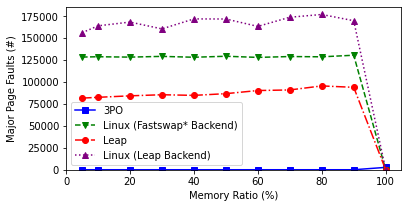

In [16]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_vec", lambda m: m.num_major_faults, "single")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

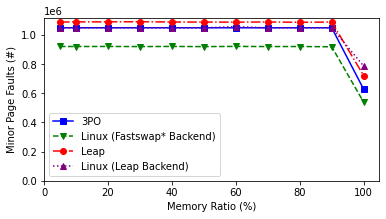

In [17]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_vec", lambda m: m.num_minor_faults, "single")

plt.ylabel("Minor Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

Dot Product (mmult_eigen_dot, size = 134217728)
-----------------------------------------------------------------------

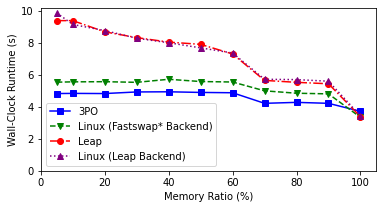

In [18]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_dot", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

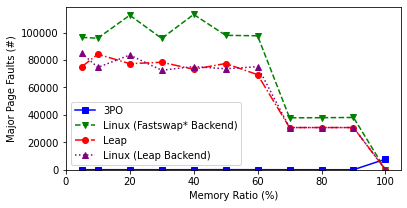

In [19]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_dot", lambda m: m.num_major_faults, "single")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

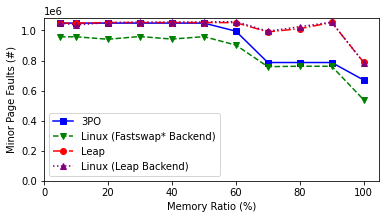

In [20]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_dot", lambda m: m.num_minor_faults, "single")

plt.ylabel("Minor Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

Sparse Matrix Multiply (sparse_eigen, size = 5500)
-----------------------------------------------------------------------

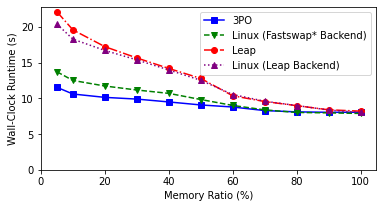

In [21]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("sparse_eigen", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

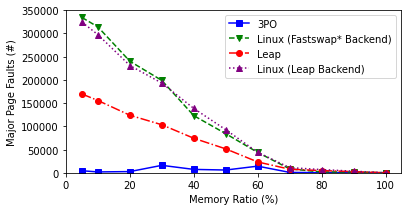

In [22]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("sparse_eigen", lambda m: m.num_major_faults, "single")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

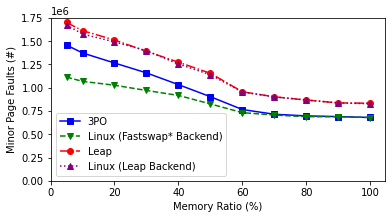

In [23]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("sparse_eigen", lambda m: m.num_minor_faults, "single")

plt.ylabel("Minor Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

Bitonic Merge (sort_merge, size = 268435456)
-----------------------------------------------------------------

In [24]:
# plt.figure(figsize = (6, 3))

# plot_tape_vs_leap("sort_merge", lambda m: m.wall_clock_time)

# plt.ylabel("Wall-Clock Runtime (s)")
# plt.xlabel("Memory Ratio (%)")

# plt.xlim(left = 0)
# plt.ylim(bottom = 0)

# plt.legend()

# plt.show()

In [25]:
# plt.figure(figsize = (6, 3))

# plot_tape_vs_leap("sort_merge", lambda m: m.num_major_faults)

# plt.ylabel("Major Page Faults (#)")
# plt.xlabel("Memory Ratio (%)")

# plt.xlim(left = 0)
# plt.ylim(bottom = 0)

# plt.legend()

# plt.show()

In [26]:
# plt.figure(figsize = (6, 3))

# plot_tape_vs_leap("sort_merge", lambda m: m.num_minor_faults)

# plt.ylabel("Minor Page Faults (#)")
# plt.xlabel("Memory Ratio (%)")

# plt.xlim(left = 0)
# plt.ylim(bottom = 0)

# plt.legend()

# plt.show()

Graphs for the Paper
------------------------------

In [27]:
mmul_style = {"label": "matmul", "color": "blue", "marker": "s", "ls": "-"}
mmul3_style = {"label": "matmul_3", "color": "pink", "marker": "*", "ls": "-"}
mvmul_style = {"label": "mvmul", "color": "green", "marker": "v", "ls": "--"}
dprod_style = {"label": "dprod", "color": "red", "marker": "o", "ls": "-."}
sparse_style = {"label": "spmul", "color": "purple", "marker": "^", "ls": ":"}

In [28]:
tape_bar_style = {"label": "3PO", "edgecolor": "black", "color": "green"}
linux_tape_bar_style = {"label": "Linux (Fastswap* Backend)", "edgecolor": "black", "color": "yellow", "hatch": "//"}
leap_bar_style = {"label": "Leap", "edgecolor": "black", "color": "pink", "hatch": "\\\\"}
linux_leap_bar_style = {"label": "Linux (Leap Backend)", "edgecolor": "black", "color": "cyan", "hatch": ".."}

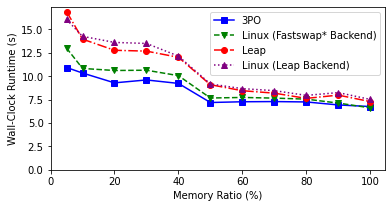

In [29]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen", lambda m: m.wall_clock_time, "single")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

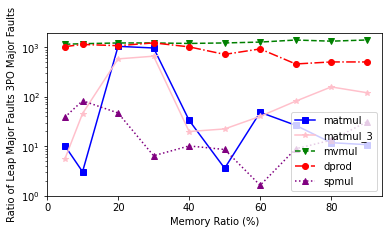

In [30]:
plt.figure(figsize = (6, 3))

mmul_tape, _, mmul_leap, _ = get_tape_vs_leap("mmult_eigen", "single")
mmul3_tape, _, mmul3_leap, _ = get_tape_vs_leap("mmult_eigen_par_3", "single")
mvmul_tape, _, mvmul_leap, _ = get_tape_vs_leap("mmult_eigen_vec", "single")
dprod_tape, _, dprod_leap, _ = get_tape_vs_leap("mmult_eigen_dot", "single")
sparse_tape, _, sparse_leap, _ = get_tape_vs_leap("sparse_eigen", "single")

def get_ratio(tape, leap, ratio):
    return leap.ratio[ratio].num_major_faults / tape.ratio[ratio].num_major_faults

# Skip 100, because we'll get 0 faults and the ratio will be undefined
non_full_ratios = RATIOS[:-1]

plt.plot(non_full_ratios, [get_ratio(mmul_tape, mmul_leap, r) for r in non_full_ratios], **mmul_style)
plt.plot(non_full_ratios, [get_ratio(mmul3_tape, mmul3_leap, r) for r in non_full_ratios], **mmul3_style)
plt.plot(non_full_ratios, [get_ratio(mvmul_tape, mvmul_leap, r) for r in non_full_ratios], **mvmul_style)
plt.plot(non_full_ratios, [get_ratio(dprod_tape, dprod_leap, r) for r in non_full_ratios], **dprod_style)
plt.plot(non_full_ratios, [get_ratio(sparse_tape, sparse_leap, r) for r in non_full_ratios], **sparse_style)

plt.ylabel("Ratio of Leap Major Faults 3PO Major Faults")
plt.xlabel("Memory Ratio (%)")

plt.yscale("log")

plt.xlim(left = 0)
plt.ylim(bottom = 1)

plt.legend()

plt.show()

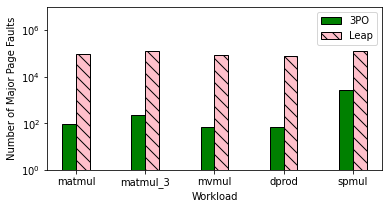

In [31]:
plt.figure(figsize = (6, 3))

mmul_tape, mmul_linux_tape, mmul_leap, mmul_linux_leap = get_tape_vs_leap("mmult_eigen", "single")
mmul3_tape, mmul3_linux_tape, mmul3_leap, mmul3_linux_leap = get_tape_vs_leap("mmult_eigen_par_3", "single")
mvmul_tape, mvmul_linux_tape, mvmul_leap, mvmul_linux_leap = get_tape_vs_leap("mmult_eigen_vec", "single")
dprod_tape, dprod_linux_tape, dprod_leap, dprod_linux_leap = get_tape_vs_leap("mmult_eigen_dot", "single")
sparse_tape, sparse_linux_tape, sparse_leap, sparse_linux_leap = get_tape_vs_leap("sparse_eigen", "single")

order = ["matmul", "matmul_3", "mvmul", "dprod", "spmul"]
tape_data = [mmul_tape, mmul3_tape, mvmul_tape, dprod_tape, sparse_tape]
linux_tape_data = [mmul_linux_tape, mmul3_linux_tape, mvmul_linux_tape, dprod_linux_tape, sparse_linux_tape]
leap_data = [mmul_leap, mmul3_leap, mvmul_leap, dprod_leap, sparse_leap]
linux_leap_data = [mmul_linux_leap, mmul3_linux_leap, mvmul_linux_leap, dprod_linux_leap, sparse_linux_leap]

SLICE_RATIO = 20
SLICE_INDEX = RATIOS.index(SLICE_RATIO)

x = np.arange(5)
width = 0.2
plt.bar(x - (width / 2), [t.ratio[SLICE_RATIO].num_major_faults for t in tape_data], width = width, **tape_bar_style)
plt.bar(x + (width / 2), [l.ratio[SLICE_RATIO].num_major_faults for l in leap_data], width = width, **leap_bar_style)
# plt.bar(x + (width / 2), [t.ratio[SLICE_RATIO].num_major_faults for t in linux_tape_data], width = width, **linux_tape_bar_style)
# plt.bar(x + 3 * (width / 2), [l.ratio[SLICE_RATIO].num_major_faults for l in linux_leap_data], width = width, **linux_leap_bar_style)

plt.ylabel("Number of Major Page Faults")
plt.xlabel("Workload")
plt.xticks(x, order)

plt.yscale("log")

# plt.xlim(left = 0)
plt.ylim(bottom = 1, top = (10 ** 7))

plt.legend()

plt.show()

Parallel Workloads
---------------------------

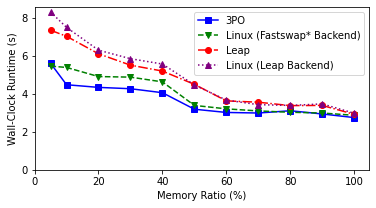

In [32]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_par_3", lambda m: m.wall_clock_time, "parallel")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

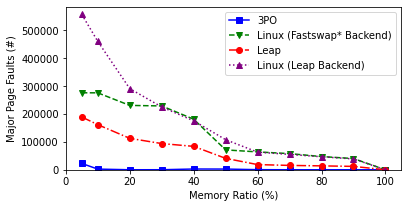

In [33]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_par_3", lambda m: m.num_major_faults, "parallel")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

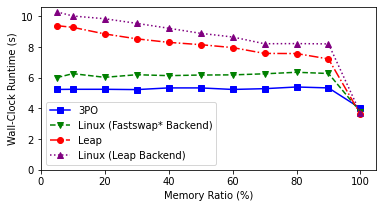

In [34]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_vec_par_3", lambda m: m.wall_clock_time, "parallel")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

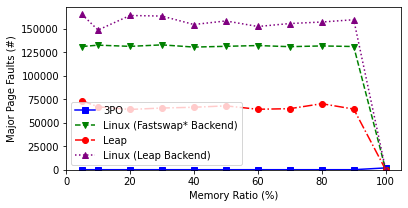

In [35]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_vec_par_3", lambda m: m.num_major_faults, "parallel")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

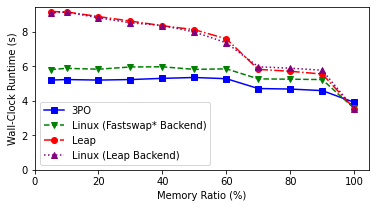

In [36]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_dot_par_3", lambda m: m.wall_clock_time, "parallel")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

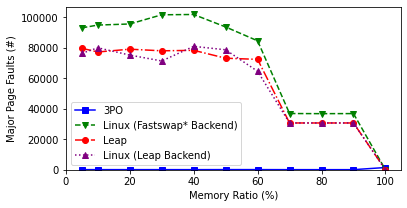

In [37]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("mmult_eigen_dot_par_3", lambda m: m.num_major_faults, "parallel")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

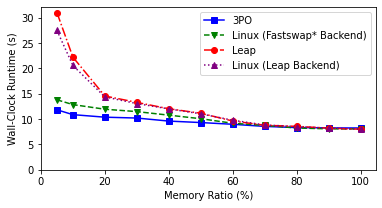

In [38]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("sparse_eigen_par_3", lambda m: m.wall_clock_time, "parallel")

plt.ylabel("Wall-Clock Runtime (s)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

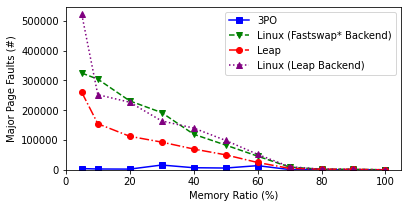

In [39]:
plt.figure(figsize = (6, 3))

plot_tape_vs_leap("sparse_eigen_par_3", lambda m: m.num_major_faults, "parallel")

plt.ylabel("Major Page Faults (#)")
plt.xlabel("Memory Ratio (%)")

plt.xlim(left = 0)
plt.ylim(bottom = 0)

plt.legend()

plt.show()

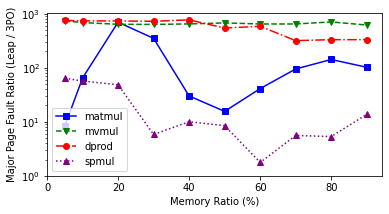

In [40]:
plt.figure(figsize = (6, 3))

mmul_tape, _, mmul_leap, _ = get_tape_vs_leap("mmult_eigen_par_3", "parallel")
mvmul_tape, _, mvmul_leap, _ = get_tape_vs_leap("mmult_eigen_vec_par_3", "parallel")
dprod_tape, _, dprod_leap, _ = get_tape_vs_leap("mmult_eigen_dot_par_3", "parallel")
sparse_tape, _, sparse_leap, _ = get_tape_vs_leap("sparse_eigen_par_3", "parallel")

def get_ratio(tape, leap, ratio):
    return leap.ratio[ratio].num_major_faults / tape.ratio[ratio].num_major_faults

# Skip 100, because we'll get 0 faults and the ratio will be undefined
non_full_ratios = RATIOS[:-1]

plt.plot(non_full_ratios, [get_ratio(mmul_tape, mmul_leap, r) for r in non_full_ratios], **mmul_style)
plt.plot(non_full_ratios, [get_ratio(mvmul_tape, mvmul_leap, r) for r in non_full_ratios], **mvmul_style)
plt.plot(non_full_ratios, [get_ratio(dprod_tape, dprod_leap, r) for r in non_full_ratios], **dprod_style)
plt.plot(non_full_ratios, [get_ratio(sparse_tape, sparse_leap, r) for r in non_full_ratios], **sparse_style)

plt.ylabel("Major Page Fault Ratio (Leap / 3PO)")
plt.xlabel("Memory Ratio (%)")

plt.yscale("log")

plt.xlim(left = 0)
plt.ylim(bottom = 1)

plt.legend()

plt.show()

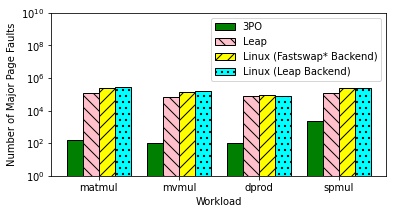

In [41]:
plt.figure(figsize = (6, 3))

mmul_tape, mmul_linux_tape, mmul_leap, mmul_linux_leap = get_tape_vs_leap("mmult_eigen_par_3", "parallel")
mvmul_tape, mvmul_linux_tape, mvmul_leap, mvmul_linux_leap = get_tape_vs_leap("mmult_eigen_vec_par_3", "parallel")
dprod_tape, dprod_linux_tape, dprod_leap, dprod_linux_leap = get_tape_vs_leap("mmult_eigen_dot_par_3", "parallel")
sparse_tape, sparse_linux_tape, sparse_leap, sparse_linux_leap = get_tape_vs_leap("sparse_eigen_par_3", "parallel")

order = ["matmul", "mvmul", "dprod", "spmul"]
tape_data = [mmul_tape, mvmul_tape, dprod_tape, sparse_tape]
linux_tape_data = [mmul_linux_tape, mvmul_linux_tape, dprod_linux_tape, sparse_linux_tape]
leap_data = [mmul_leap, mvmul_leap, dprod_leap, sparse_leap]
linux_leap_data = [mmul_linux_leap, mvmul_linux_leap, dprod_linux_leap, sparse_linux_leap]

SLICE_RATIO = 20
SLICE_INDEX = RATIOS.index(SLICE_RATIO)

x = np.arange(len(order))
width = 0.2
plt.bar(x - 3 * (width / 2), [t.ratio[SLICE_RATIO].num_major_faults for t in tape_data], width = width, **tape_bar_style)
plt.bar(x - (width / 2), [l.ratio[SLICE_RATIO].num_major_faults for l in leap_data], width = width, **leap_bar_style)
plt.bar(x + (width / 2), [t.ratio[SLICE_RATIO].num_major_faults for t in linux_tape_data], width = width, **linux_tape_bar_style)
plt.bar(x + 3 * (width / 2), [l.ratio[SLICE_RATIO].num_major_faults for l in linux_leap_data], width = width, **linux_leap_bar_style)

plt.ylabel("Number of Major Page Faults")
plt.xlabel("Workload")
plt.xticks(x, order)

plt.yscale("log")

# plt.xlim(left = 0)
plt.ylim(bottom = 1, top = (10 ** 10))

plt.legend()

plt.show()